## Montando uma Rede Neural Convolucional (CNN)
* Convolução
    * conv2d
* Pooling
    * MaxPooling2D    
    * AveragePooling2D

In [2]:
from rubia_cnn import * 

## Avaliando a Rede Neural com dados da base MNIST (dígitos)
* Dividindo os valores por 255 para normalização (transforma para 0~1)

In [18]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print('Train X shape:', train_images.shape)
print('Train y shape:', train_labels.shape)

k = cnn_keras(X=train_images, y=train_labels, gpu=True, workers=1)

Train X shape: (60000, 28, 28, 1)
Train y shape: (60000, 10)

Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU enabled!
Using 1 GPU workers
CPU test for EYE(10000):  0.2844059467315674
GPU test for EYE(10000):  0.000377655029296875
Multiprocessing status: False

Neural network setup:
X data shape:             (60000, 28, 28, 1)
y data shape:             (60000, 10)


## Normalmente, redes CNNs são montadas da seguinte forma:
* Sequência de camadas de convolução e pooling
* Camada flatten
    * Realiza uma operação de transformar um vetor com múltiplas dimensões para um vetor com apenas uma dimensão. Necessário para adequar corretamente o resultado da convolução com a camada de classificação
* Camada densa com ativação softmax para classificação

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

* Após o processo de Convolução é utilizada uma camada Dense antecedida de uma camada Flatten para classificar entre as classes

In [20]:
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
print('\nTraining started...')
history = model.fit(k.X, k.y, epochs=5, batch_size=16, verbose=2, validation_split=0.2, 
          shuffle=True, workers=k.workers, use_multiprocessing=k.multicore)


Training started...
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 - 5s - loss: 0.1554 - accuracy: 0.9542 - val_loss: 0.0950 - val_accuracy: 0.9734
Epoch 2/5
48000/48000 - 5s - loss: 0.0866 - accuracy: 0.9747 - val_loss: 0.0796 - val_accuracy: 0.9776
Epoch 3/5
48000/48000 - 5s - loss: 0.0728 - accuracy: 0.9791 - val_loss: 0.0765 - val_accuracy: 0.9787
Epoch 4/5
48000/48000 - 6s - loss: 0.0668 - accuracy: 0.9809 - val_loss: 0.0719 - val_accuracy: 0.9810
Epoch 5/5
48000/48000 - 5s - loss: 0.0627 - accuracy: 0.9823 - val_loss: 0.0722 - val_accuracy: 0.9803


In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Acurácia:', test_acc)

10000/10000 [==============================] - 1s 89us/sample - loss: 0.0609 - accuracy: 0.9806
Acurácia: 0.9806


## Utilizando rede Neural Treinada para realizar predição

In [26]:
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import Xception # TensorFlow ONLY
#from tensorflow.keras.applications import VGG19

## VGG16

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

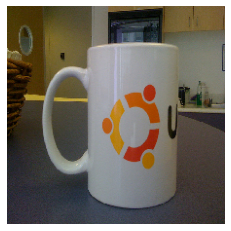

1. coffee_mug: 75.27%
2. coffeepot: 8.37%
3. cup: 6.44%
4. teapot: 3.03%
5. pitcher: 2.59%


In [13]:
model = VGG16()

image = load_img('figs/mug.jpg', target_size=(224, 224))
#image = load_img('figs/mug.jpg', target_size=(299, 299))

plt.imshow(image)
plt.axis('off')
plt.show()

image = img_to_array(image)

# acertar formato do array para o modelo
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# preprocessamento da imagem
image = preprocess_input(image)

# calcular probabilidade considerando todos os "labels"
yhat = model.predict(image)

# Codificar as probabilidades retornadas nos "labels"
label = decode_predictions(yhat)

for (i, (imagenetID, label, prob)) in enumerate(label[0]):
    print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

## ImageNet

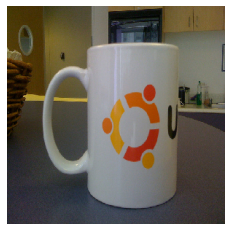

1. web_site: 100.00%
2. stopwatch: 0.00%
3. cup: 0.00%
4. sunglass: 0.00%
5. mink: 0.00%


In [15]:
from tensorflow.keras.applications import InceptionV3

model = InceptionV3(weights='imagenet')

image = load_img('figs/mug.jpg', target_size=(299, 299))

plt.imshow(image)
plt.axis('off')
plt.show()

x = img_to_array(image)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

yhat = model.predict(x)

label = decode_predictions(yhat)

for index, res in enumerate(label[0]):
    print('{}. {}: {:.2f}%'.format(index + 1, res[1], 100 * res[2]))

## Comparando MLP x CNN

In [42]:
def create_test_data(path):
    X, y = [], []
    convert = lambda category : int(category == 'dog')
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path, p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(category)
    return X, y

In [25]:
import cv2

main_dir = "/home/lazarop/Downloads/dogs-vs-cats/"
train_dir = "train"
path = os.path.join(main_dir, train_dir)

X, y = create_test_data(path)

X = np.array(X).reshape(-1, 80,80,1)
y = np.array(y)
y = to_categorical(y)

k = cnn_keras(X=X, y=y, gpu=True, workers=1)


Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU enabled!
Using 1 GPU workers
CPU test for EYE(10000):  0.26541686058044434
GPU test for EYE(10000):  0.014838933944702148
Multiprocessing status: False

Neural network setup:
X data shape:             (25000, 80, 80, 1)
y data shape:             (25000, 2)


# CNN
* conv2d
* maxpooling2d
* padding
    * same = aplica valores 0 ao redor de toda imagem, mantendo tamanho original da matriz após aplicar filtros   

In [50]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(80, 80, 1), padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(k.X, k.y, epochs=5, batch_size=256, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 30s 1ms/sample - loss: 29.8003 - accuracy: 0.5173 - val_loss: 0.6992 - val_accuracy: 0.4938
Epoch 2/5
20000/20000 [==============================] - 23s 1ms/sample - loss: 0.7129 - accuracy: 0.5300 - val_loss: 0.7600 - val_accuracy: 0.4940
Epoch 3/5
20000/20000 [==============================] - 23s 1ms/sample - loss: 0.7309 - accuracy: 0.5451 - val_loss: 0.7766 - val_accuracy: 0.5060
Epoch 4/5
20000/20000 [==============================] - 23s 1ms/sample - loss: 0.7463 - accuracy: 0.5903 - val_loss: 0.6971 - val_accuracy: 0.6030
Epoch 5/5
20000/20000 [==============================] - 24s 1ms/sample - loss: 0.6570 - accuracy: 0.6594 - val_loss: 0.6538 - val_accuracy: 0.5982


# MLP

In [51]:
Xmlp = np.array(k.X).reshape(25000, 6400)

model = models.Sequential()

model.add(layers.Dense(2048, activation='relu', input_shape=(6400,)))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(Xmlp, k.y, epochs=5, batch_size=512, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 1s 75us/sample - loss: 1275.5907 - accuracy: 0.5027 - val_loss: 5.9941 - val_accuracy: 0.4940
Epoch 2/5
20000/20000 [==============================] - 1s 47us/sample - loss: 9.9598 - accuracy: 0.4965 - val_loss: 4.7462 - val_accuracy: 0.4940
Epoch 3/5
20000/20000 [==============================] - 1s 47us/sample - loss: 2.2139 - accuracy: 0.5044 - val_loss: 1.3891 - val_accuracy: 0.4940
Epoch 4/5
20000/20000 [==============================] - 1s 46us/sample - loss: 4.0922 - accuracy: 0.4990 - val_loss: 0.7225 - val_accuracy: 0.4940
Epoch 5/5
20000/20000 [==============================] - 1s 46us/sample - loss: 1.4325 - accuracy: 0.5023 - val_loss: 0.8246 - val_accuracy: 0.5060
